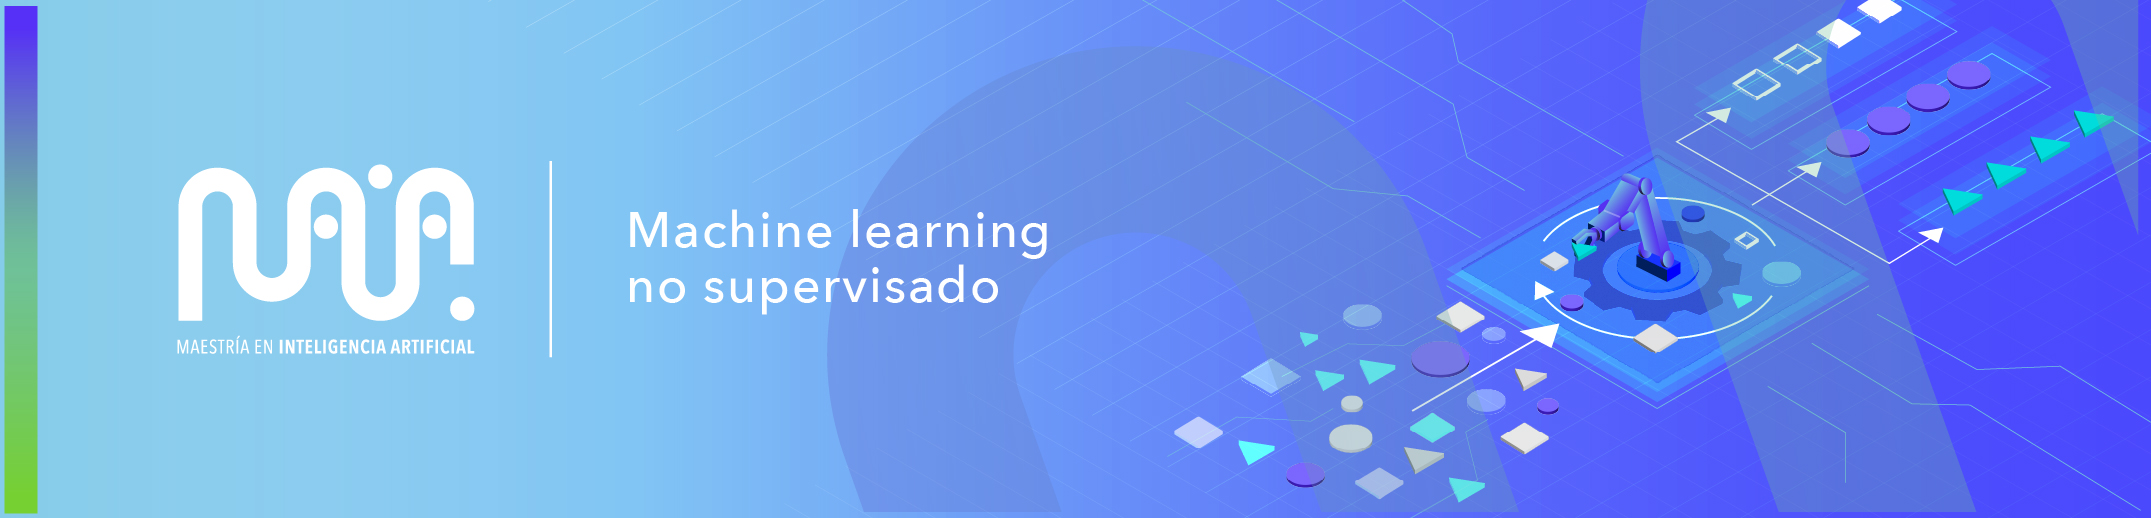

# Solución de problemas con KMeans y KMedoides - caso ideal

En este tutorial aprenderás cómo crear un modelo de agrupación haciendo uso del algoritmo KMeans y del algoritmo KMedoides. En particular, realizarás una selección del hiperparámetro k mediante el método del codo y el método de la silueta, interpretando los grupos del mejor modelo de agrupación resultante. En este sentido, veremos cómo realizar los siguientes procesos:

1. [Importar las librerías necesarias.](#1.-Importación-de-librerías-requeridas)
2. [Cargar y procesar un conjunto de datos.](#2.-Carga-de-datos)
3. [Seleccionar el hiperparámetro K para KMeans mediante el método del codo y el método de la silueta.](#3.-Selección-del-hiperparámetro-K-para-KMeans)
4. [Seleccionar el hiperparámetro K para KMedoides mediante el método del codo y el método de la silueta.](#4.-Selección-del-hiperparámetro-K-para-KMedoides)
5. [Interpretar los grupos resultantes del mejor modelo.](#5.-Interpretación-de-los-grupos-resultantes-del-mejor-modelo)

 ---
 
    
<font size="3">**Contexto**  
<font size="2"> El conjunto de datos que utilizaremos se relaciona con la caracterización de vinos con base en atributos como el pH, la cantidad de dióxido de azufre, azúcar residual, entre otros. Este conocimiento puede resultar muy útil en la certificación de la calidad de una muestra de vino a partir de variables fisicoquímicas. Los datos han sido descargados a partir de este [enlace](https://www.kaggle.com/datasets/rajyellow46/wine-quality) y modificados para propósitos de este ejercicio. Es un caso ideal que permitirá ejemplificar todo el proceso.  
Cita: Cortez,Paulo, Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). Wine Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `numpy` y `scikit-learn`, así como la librería `sklearn_extra` para usar el algoritmo KMedoides (recuerda que si no has instalado la librería `sklearn_extra`debes hacerlo con `pip install scikit-learn-extra`). Adicionalmente, importaremos dos librerías para visualización: `matplotlib` y `seaborn`. Usaremos las siguientes clases y funciones para entrenar y evaluar los modelos de agrupación:

* [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): clase para realizar la normalización de valores numéricos.
* [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html): función para obtener el valor promedio del coeficiente de la silueta.
* [`silhouette_samples()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html): función para obtener el coeficiente de la silueta para cada ejemplo.
* [`KMeans()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html): clase para crear el modelo de KMeans.
* [`KMedoids()`](https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html): clase para crear el modelo de KMedoides.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

## 2. Carga de datos

Realizaremos la carga de datos usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data_raw = pd.read_csv('./data/wine_quality.csv', sep=',')
data_raw

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,11.091418,0.678736,1.166757,51.224667,0.196503,95.102349,81.153415,0.998144,3.642585,0.425207,12.273098
1,11.368098,0.714899,1.076856,51.757659,0.150704,94.925272,80.229619,0.995853,3.766852,0.629721,12.237926
2,10.681273,0.854871,1.432067,55.325475,0.097510,117.321509,327.596772,1.034387,2.966008,0.846459,12.954406
3,14.136565,0.940244,0.263259,28.526766,0.428167,243.641087,331.235036,1.004244,3.076522,1.638521,12.459896
4,11.286462,0.622551,1.167118,56.337446,0.141715,85.887796,78.834860,0.998896,3.864429,0.474253,12.290298
...,...,...,...,...,...,...,...,...,...,...,...
6492,9.812656,0.519421,1.459374,56.361282,0.102864,78.675282,353.406283,1.031746,3.142622,0.829744,13.233414
6493,13.290458,0.792301,0.220811,24.958493,0.371316,254.372135,364.995441,1.004352,2.970350,1.710251,12.567409
6494,14.844921,0.865045,0.300987,24.598068,0.418014,215.547898,369.972034,0.999167,2.910071,1.849681,13.845125
6495,11.230268,0.639650,1.078172,54.398855,0.176503,113.334984,83.883090,0.998868,3.741809,0.418961,12.154768


Inicialmente veremos si se tienen datos nulos usando las funciones `isna().sum()`:

In [3]:
data_raw.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

Como no se tienen datos nulos, verificaremos si se tienen datos duplicados usando `duplicated().sum()`:

In [4]:
data_raw.duplicated().sum()

0

### Procesamiento del conjunto

Al no tener que preocuparnos por datos nulos o duplicados, nuestro procesamiento solamente consistirá en la estandarización del conjunto. Inicialmente, utilizaremos la función `copy()` para obtener una copia del conjunto de datos original:

In [5]:
data = data_raw.copy()

Utilizaremos un objeto de la clase `StandardScaler()` para realizar la estandarización:

In [6]:
standard_scaler = StandardScaler()

Aplicaremos el método `fit_transform()` sobre nuestro conjunto:

In [7]:
data_scaler = standard_scaler.fit_transform(data)
data_scaler

array([[ 0.01468595, -0.59841393,  0.68786434, ...,  1.02314153,
        -1.21636065, -0.20444141],
       [ 0.11694956, -0.42948281,  0.48937461, ...,  1.38669259,
        -0.79189287, -0.23449219],
       [-0.13690796,  0.22438041,  1.27363059, ..., -0.95622609,
        -0.3420538 ,  0.3776553 ],
       ...,
       [ 1.40201992,  0.27190836, -1.22363595, ..., -1.11987347,
         1.7401295 ,  1.13866903],
       [ 0.06600644, -0.78100143,  0.49227986, ...,  1.31342596,
        -1.22932397, -0.30554041],
       [-2.20702673,  0.0064881 , -0.34383991, ..., -0.85730453,
         0.20822495, -1.72792081]])

Y finalmente utilizaremos el parámetro `columns` para reconstruir el DataFrame:

In [8]:
data = pd.DataFrame(data_scaler, columns=data_raw.columns)
data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.014686,-0.598414,0.687864,0.647556,-0.490277,-0.481295,-1.087387,-0.860845,1.023142,-1.216361,-0.204441
1,0.116950,-0.429483,0.489375,0.679115,-0.788505,-0.483734,-1.094311,-1.029712,1.386693,-0.791893,-0.234492
2,-0.136908,0.224380,1.273631,0.890364,-1.134886,-0.175259,0.759525,1.811517,-0.956226,-0.342054,0.377655
3,1.140204,0.623189,-1.306935,-0.696380,1.018252,1.564610,0.786791,-0.411051,-0.632910,1.301869,-0.044845
4,0.086776,-0.860876,0.688661,0.950283,-0.847040,-0.608213,-1.104763,-0.805384,1.672159,-1.114566,-0.189747
...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.457958,-1.342634,1.333921,0.951694,-1.100024,-0.707555,0.952948,1.616831,-0.439531,-0.376746,0.616034
6493,0.827474,-0.067910,-1.400654,-0.907656,0.648059,1.712415,1.039801,-0.403096,-0.943525,1.450743,0.047012
6494,1.402020,0.271908,-1.223636,-0.928997,0.952140,1.177667,1.077096,-0.785361,-1.119873,1.740129,1.138669
6495,0.066006,-0.781001,0.492280,0.835499,-0.620511,-0.230167,-1.066930,-0.807461,1.313426,-1.229324,-0.305540


Los algoritmos de agrupación pueden ser utilizados con cualquier subconjunto de variables, por ejemplo, solamente con las variables numéricas. Como nuestro conjunto de datos es solamente numérico, en este tutorial ejecutaremos KMeans y KMedoides con todas las variables.

## 3. Selección del hiperparámetro K para KMeans

Realizaremos dos pruebas para la selección del hiperparámetro _k_: el método del codo y el método de la silueta. Estos métodos permiten comparar la naturaleza de los clusters formados con los algoritmos de agrupación, cuantificando la distancia de los puntos a su centroide. Empezaremos con el método del codo. 

### Método del codo

Primero intentaremos buscar el mejor valor de _k_, representado por el parámetro `n_clusters` de `KMeans`, mediante el método del codo. Este método utiliza la inercia, o la suma de los cuadrados de las distancias de todos los puntos al centroide más cercano. En ese sentido, definiremos la función `elbow_plot()`, que ejecutará el algoritmo de agrupación con cada valor de _k_ definido por el rango `[k_min, k_max]`, generando una gráfica con los valores de inercia resultantes:

In [9]:
def elbow_plot(X, model, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo usando KMeans
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    inertias = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el valor de inercia
        inertias.append(model_k.inertia_)
    
    # Graficamos los valores de inercia
    plt.plot(range(k_min,k_max+1), inertias, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.grid()
    plt.show()

Con la función construida, veremos el comportamiento para nuestro conjunto de datos:

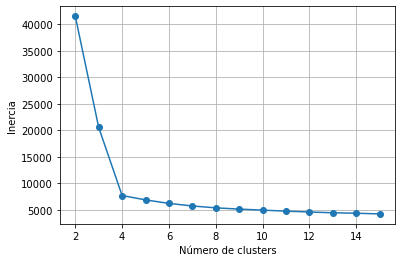

In [10]:
elbow_plot(data, "kmeans", 2, 15)

El mejor valor de _k_ se determina con el punto después del cual la inercia empieza a tener un comportamiento aproximadamente lineal, es decir, cuando el aumento del número de grupos no representa una disminución considerable de la inercia. Por ejemplo, para nuestro conjunto de datos, tenemos un codo en `k=4`, valor en el cual se presenta un cambio considerable en el comportamiento de la inercia.

### Método de la silueta

El método de la silueta es un tipo de análisis que mide la separación entre los clusters obtenidos en algoritmos de agrupación. Específicamente, el coeficiente de la silueta es un valor calculado utilizando la distancia entre clusters y la distancia al cluster más cercano para cada dato, retornando un valor entre -1 y 1. Valores cercanos a 1 indican que un dato está lejos de los demás clusters, mientras que valores cercanos a -1 indican que un dato está más cerca a otro cluster que al que fue asignado.

Para este análisis, utilizaremos la función `silhouette_score()` de `scikit-learn`, que retorna el promedio del coeficiente de la silueta para todos los datos del conjunto. En ese sentido, un valor promedio cercano a 1 nos indicaría que el número de clusters es apropiado para el conjunto de datos, mientras que valores más bajos indicarían que el valor de _k_ no retorna buenos clusters. Definiremos la función `silhouette_plot()`, que calcula el coeficiente promedio para varios valores de _k_ y los grafica:

In [11]:
def silhouette_plot(X, model, k_min=2, k_max=5):
    """
    Genera la gráfica con el coeficiente de la silueta
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    scores = []
    for i in range(k_min, k_max+1):
        if model == "kmeans":
            model_k = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
        else:
            model_k = KMedoids(n_clusters=i, max_iter=300, random_state=0)
        # Entrenamos el modelo
        model_k.fit(X)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(X, model_k.labels_)
        scores.append(score)
    
    # Graficamos los valores del coeficiente de la silueta
    plt.plot(range(k_min,k_max+1), scores, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

Veremos el comportamiento del coeficiente para nuestro conjunto de datos:

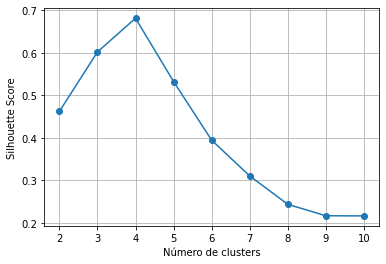

In [12]:
silhouette_plot(data, "kmeans", 2, 10)

Como puedes observar, es más evidente que el mejor valor de _k_ es 4, al ser el valor más cercano a 1 para el coeficiente de la silueta. Este análisis utiliza el coeficiente promedio obtenido entre todos los clusters. Para obtener una descripción más detallada del coeficiente de la silueta para cada cluster en cada escenario, definiremos la función `silhouette_analysis()`, basada en el siguiente [ejemplo](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) de la documentación de `scikit-learn`:

In [13]:
def silhouette_analysis(X, model, k_min, k_max):
    """
    Genera gráficas con el coeficiente de la silueta para cada cluster y cada ejemplo
    
    Parametros:
    X : np.array
        El arreglo con los datos
    model : str
        "kmeans" o "kmedoids", especifica el modelo a entrenar.
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    for n_clusters in range(k_min, k_max+1):
        if model == "kmeans":
            clusterer = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
        else:
            clusterer = KMedoids(n_clusters=n_clusters, random_state=0)
        
        # Entrenamos el modelo
        cluster_labels = clusterer.fit_predict(X)
        # Obtenemos el coeficiente promedio
        silhouette_avg = silhouette_score(X, cluster_labels)
        # Obtenemos el coeficiente para cada ejemplo
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        
        # Inicializamos una figura
        fig = plt.figure(figsize = (18, 7))
        plt.xlim([-0.2, 1])
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])
        
        y_lower = 10
        for i in range(n_clusters):
            # Obtenemos los valores del coeficiente para cada cluster
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            # Ordenamos los valores de mayor a menor
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        plt.title(f"Método de la silueta (k={n_clusters})")
        plt.xlabel("Coeficiente")
        plt.ylabel("Cluster")
        
        # Incluimos el valor promedio
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.yticks([])
        plt.xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

Realizaremos el análisis específico para el mismo rango de _k_:

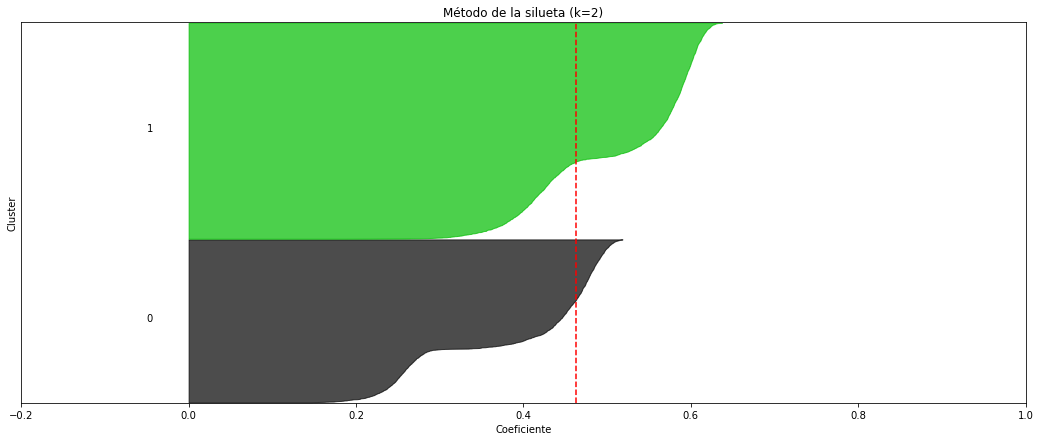

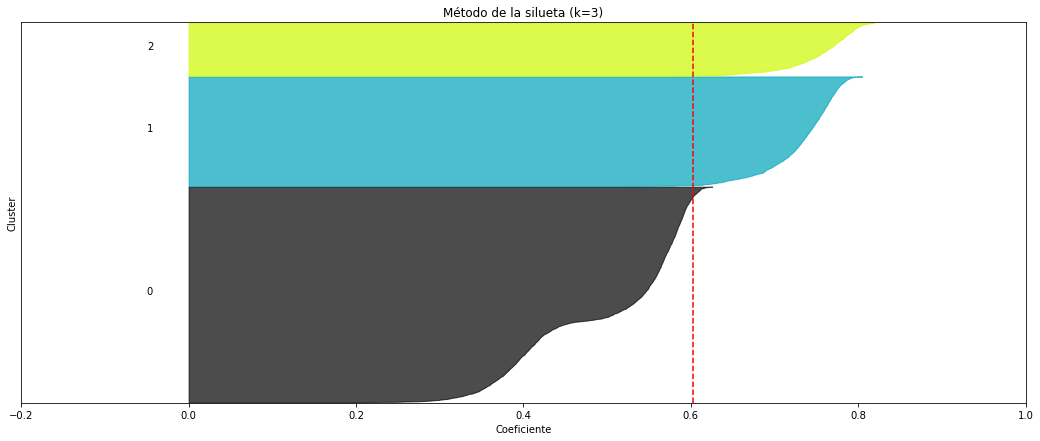

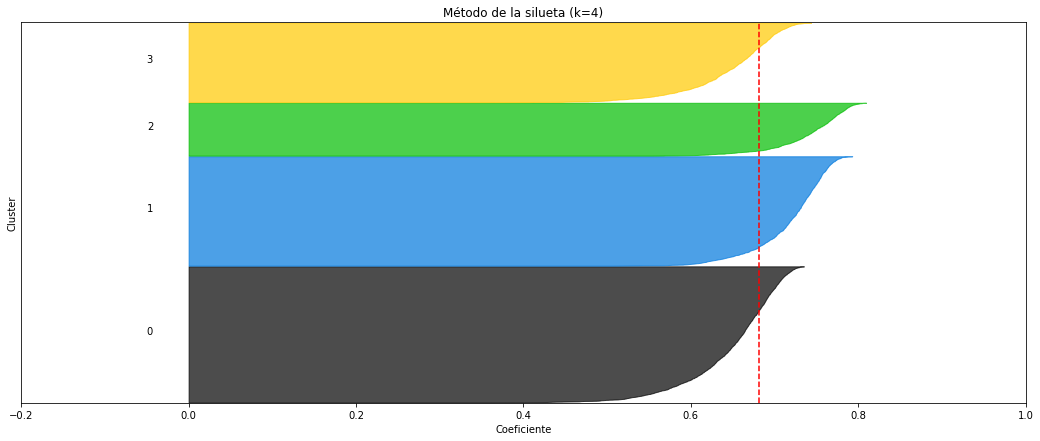

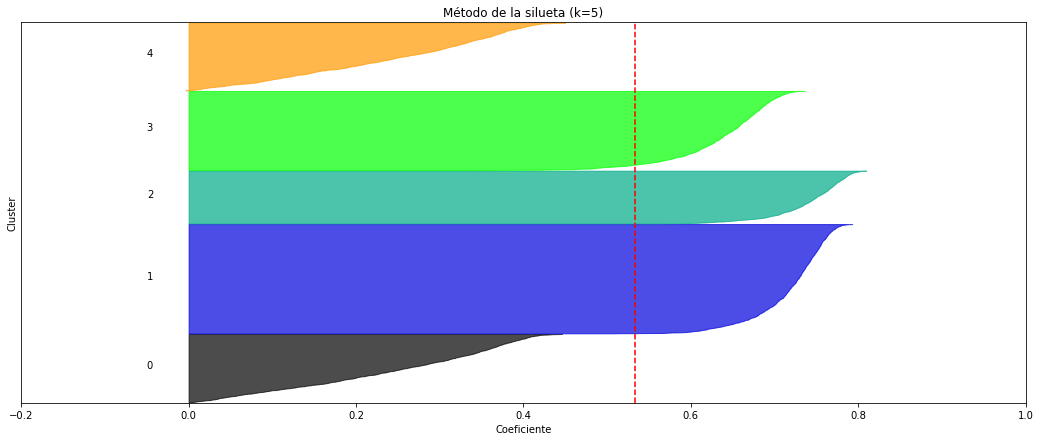

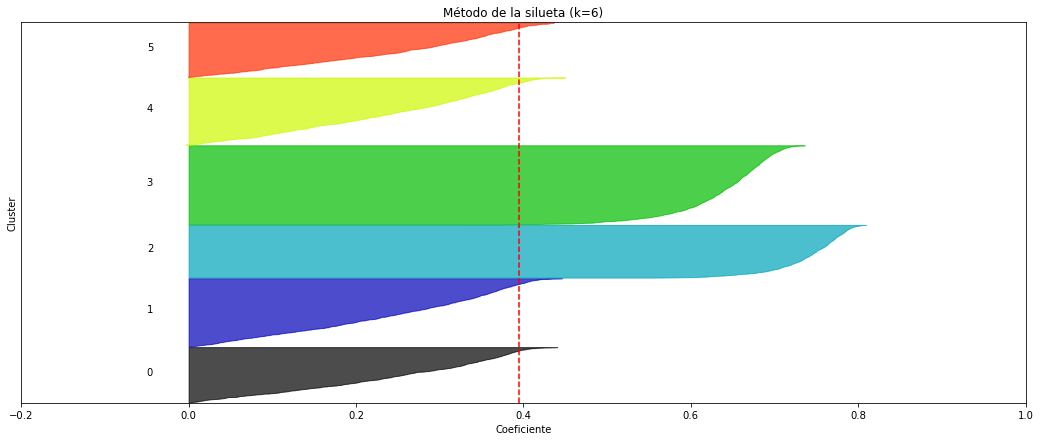

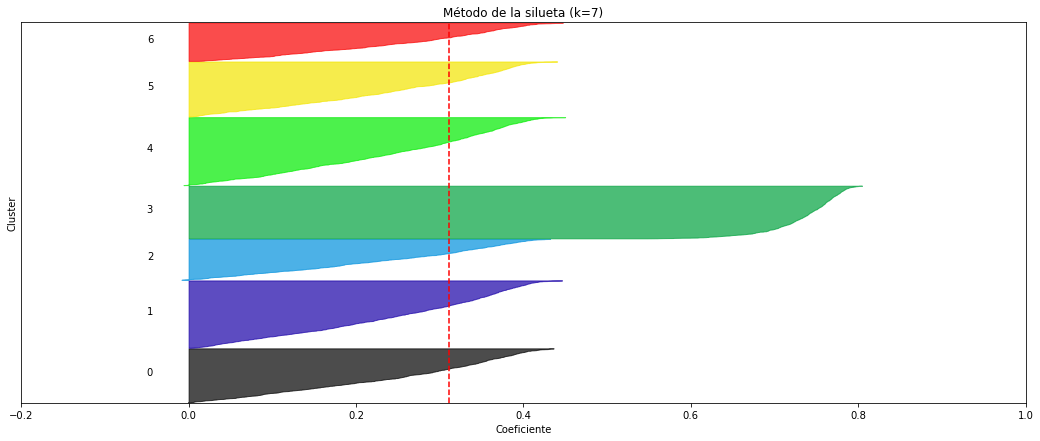

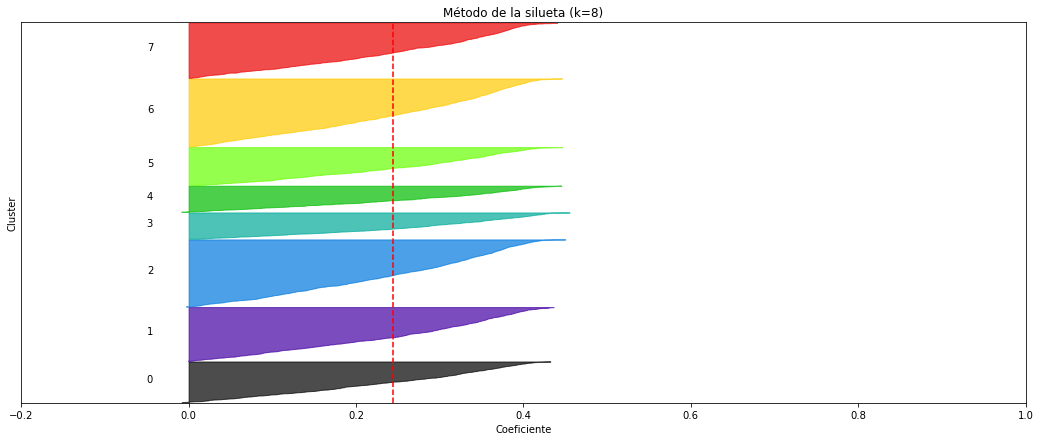

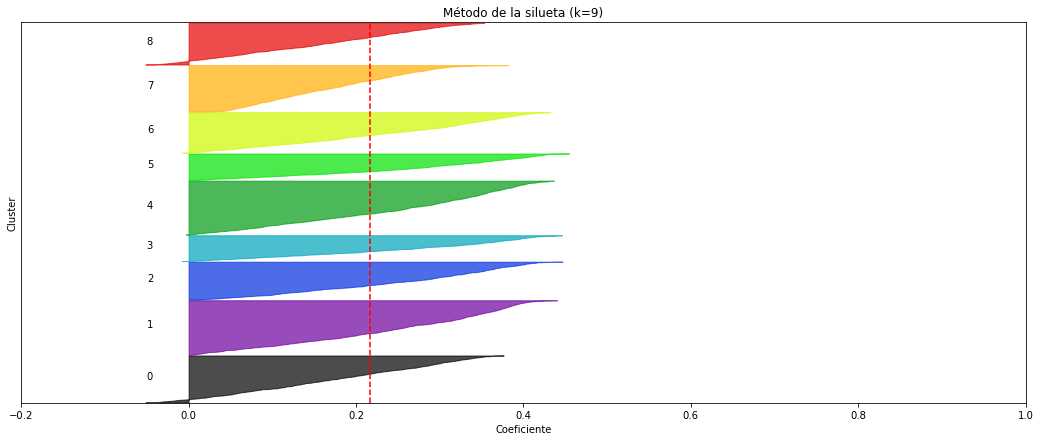

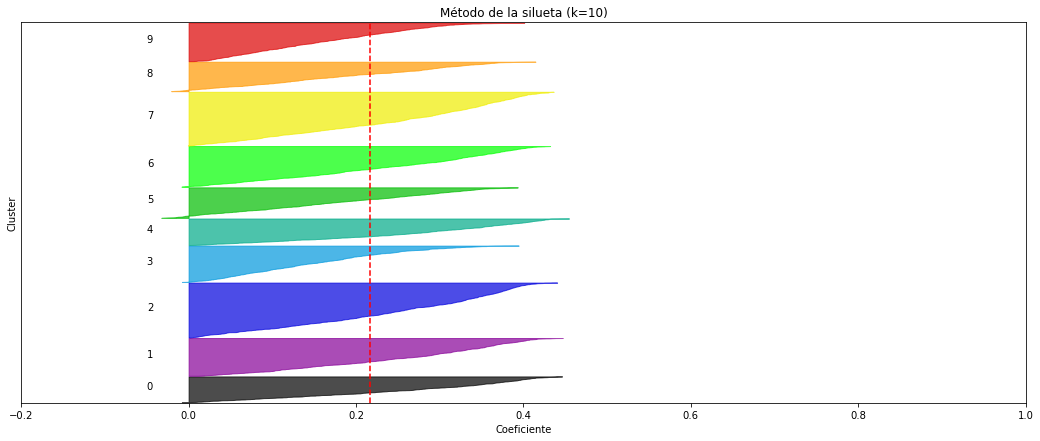

In [14]:
silhouette_analysis(data, "kmeans", 2, 10)

Si tomamos como ejemplo la gráfica para `k=4`, podemos observar los tamaños de los clusters y el comportamiento de cada ejemplo asignado a ellos. En general, los coeficientes son todos positivos y tienen un valor por encima de 0.4. Si observas las gráficas para valores de _k_ más altos, puedes ver coeficientes de menor magnitud e incluso valores negativos para algunos clusters en `k=9` y `k=10`.

## 4. Selección del hiperparámetro K para KMedoides

Ahora utilizaremos las mismas funciones pero cambiando el algoritmo a KMedoides. Este algoritmo también intenta minimizar las distancias entre puntos en un cluster y su centro pero, a diferencia de KMeans, utiliza uno de los datos como centroide para cada cluster.

### Método del codo

Primero intentaremos buscar el mejor valor de _k_, representado por el parámetro `n_clusters` de `KMedoids`, mediante el método del codo implementado en la función `elbow_plot()`:

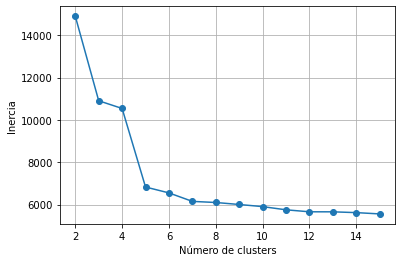

In [15]:
elbow_plot(data, "kmedoids", 2, 15)

Teniendo en cuenta que nuestro algoritmo está inicializado solamente con los parámetros `n_clusters`, `max_iter` y `random_state`, estamos utilizando la distancia euclidiana (parámetro `metric`) y una heurística para inicializar los centroides como los puntos con una menor suma de distancias a los demás puntos (parámetro `init`). 

Ten en cuenta que, aunque la métrica de distancia es igual a la clase `KMeans`, los valores de inercia para la clase `KMedoids` se calculan como la suma de las distancias de cada punto a su centroide, mientras que en el caso anterior se calculaban como las distancias al cuadrado. 

Con respecto al método del codo, ahora tenemos dos posibles codos en `k=3` y `k=5`. Si solamente tenemos en cuenta el caso en el que la inercia empieza a tener un comportamiento aproximadamente lineal, entonces el mejor valor de _k_ estaría en `k=5`.

### Método de la silueta

Ahora utilizaremos la función `silhouette_plot()` para calcular el coeficiente promedio para varios valores de _k_ usando KMedoides:

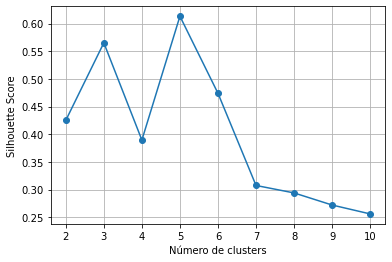

In [16]:
silhouette_plot(data, "kmedoids", 2, 10)

En este caso, como solo necesitamos las etiquetas de cluster asignadas a cada punto para calcular el coeficiente de la silueta, podemos comparar directamente el desempeño de ambos algoritmos. Como puedes observar, tenemos coeficientes de menor valor con respecto a KMeans, siendo `k=5` el que presenta el valor más cercano a 1 para el coeficiente de la silueta. En ese sentido, podemos evidenciar que KMeans parece resultar en clusters mejor definidos, al tener un valor máximo más alto. Igualmente, realizaremos el mismo análisis detallado mediante la función `silhouette_analysis()`:

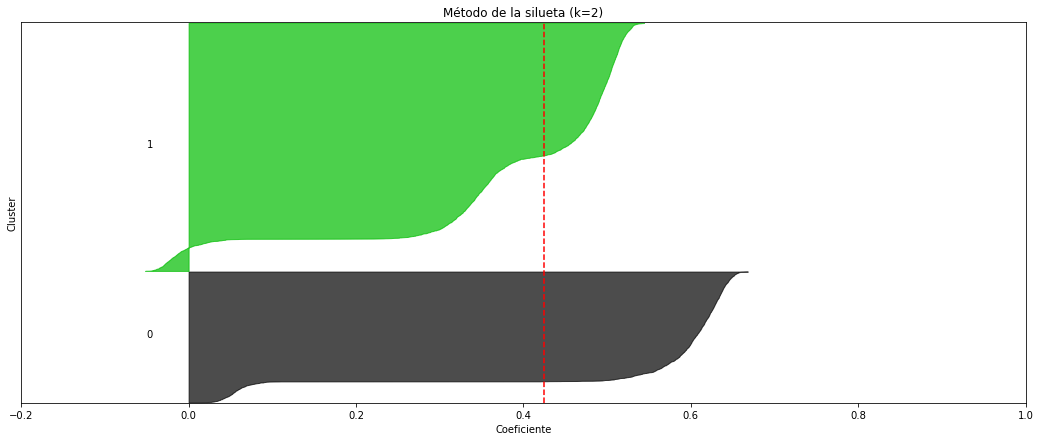

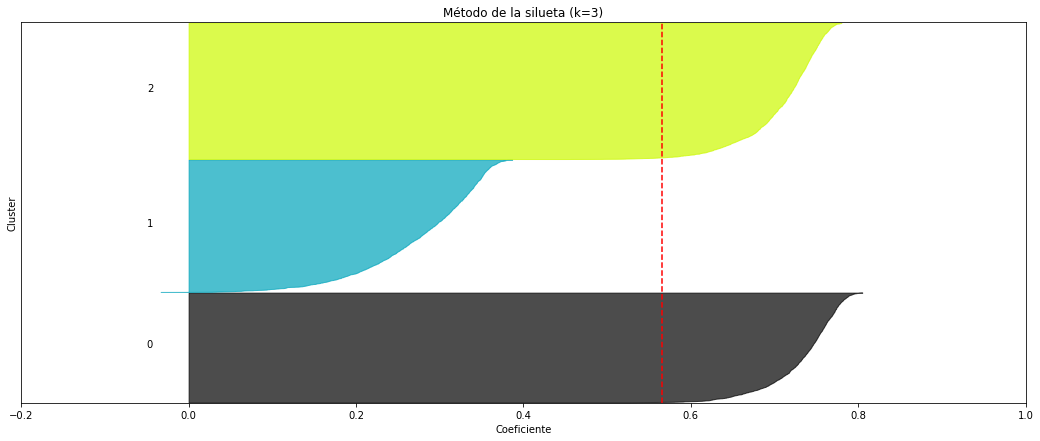

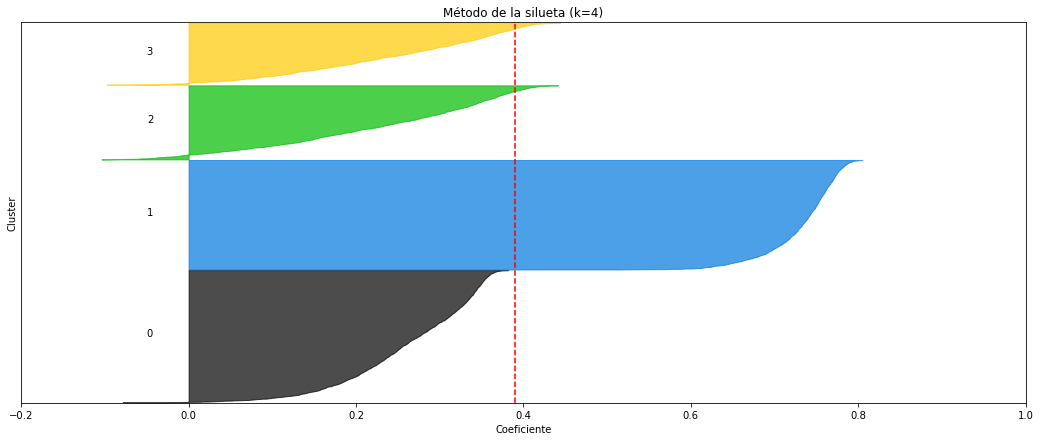

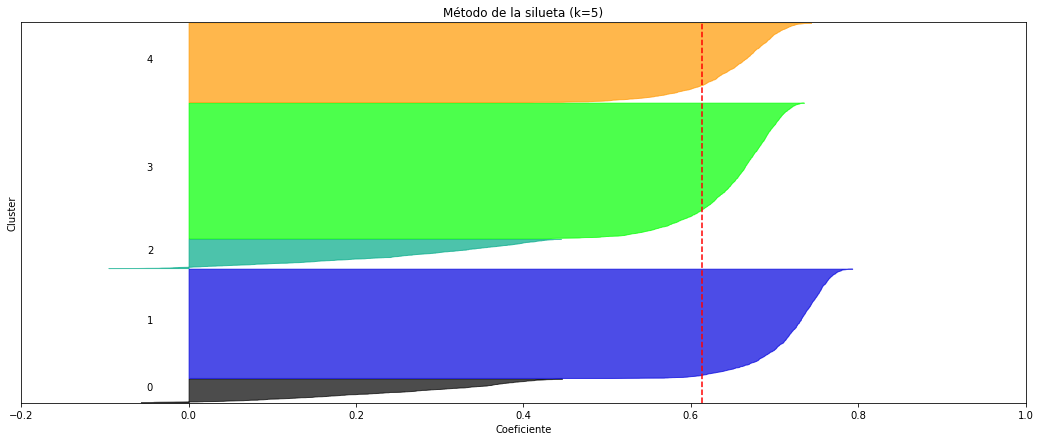

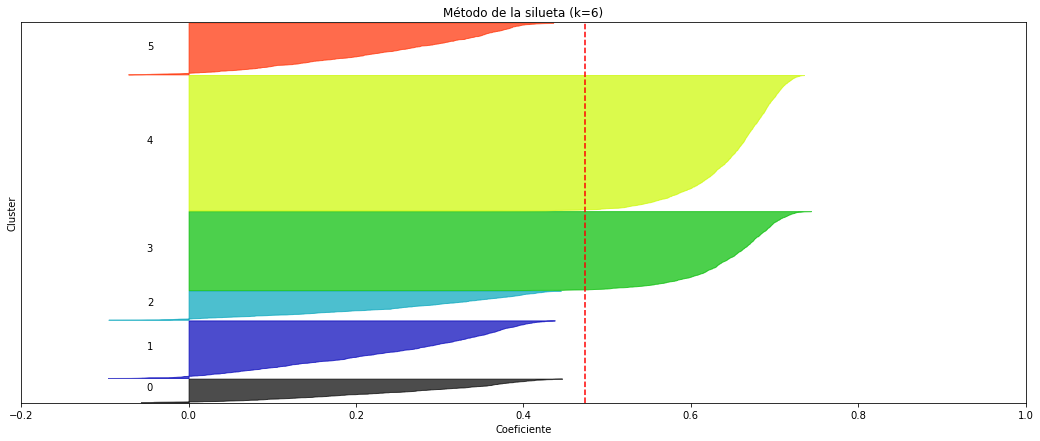

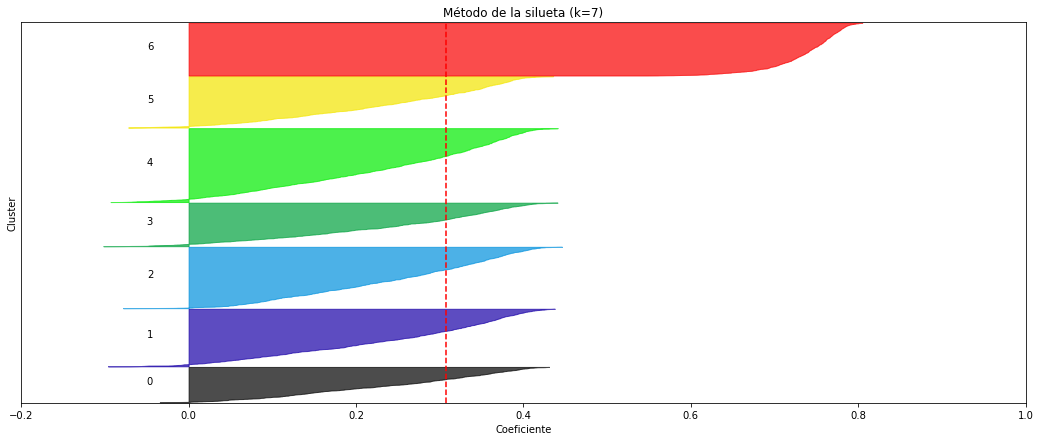

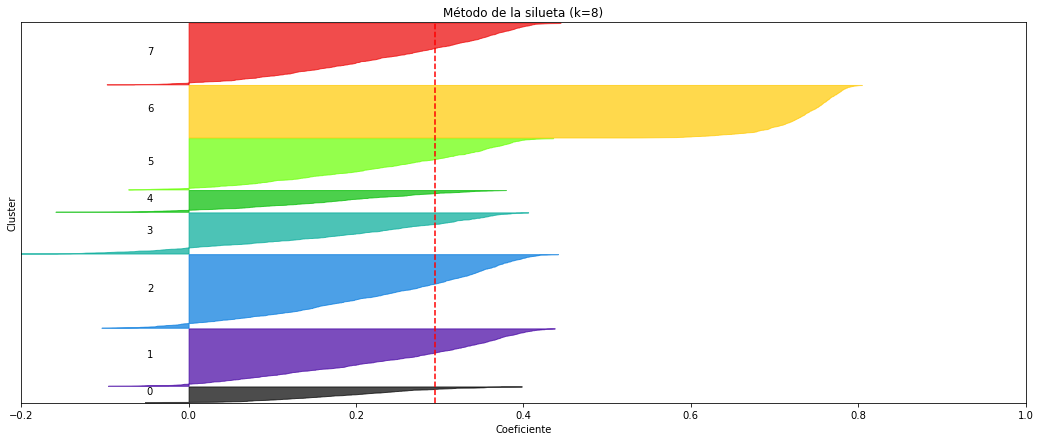

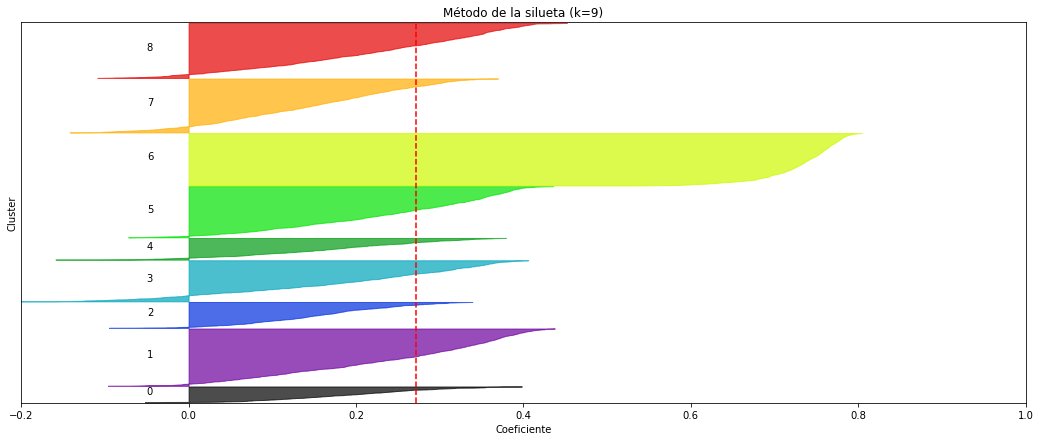

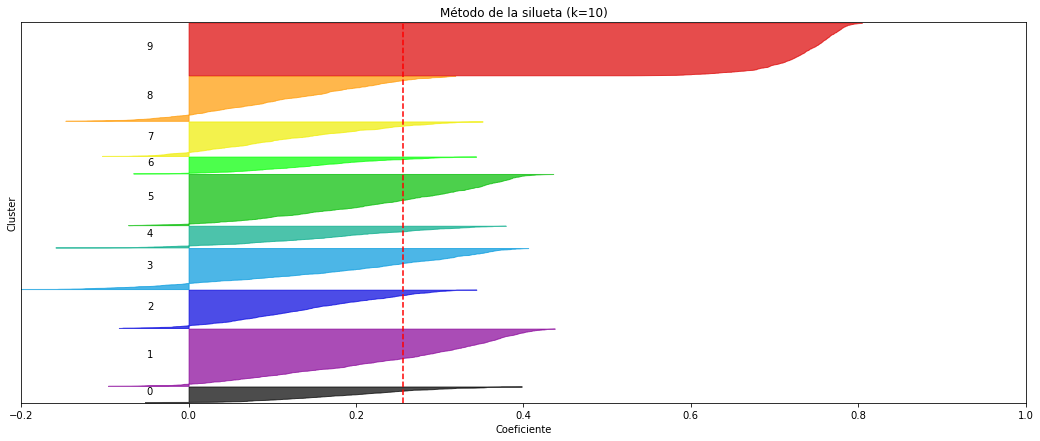

In [17]:
silhouette_analysis(data, "kmedoids", 2, 10)

Como puedes ver, los ejemplos con coeficiente negativo son más comunes, e incluso presentan una mayor magnitud. Particularmente, para `k=5`, se tienen dos clusters con valores bajos para el coeficiente de la silueta, e incluso algunos ejemplos con coeficientes negativos.

## 5. Interpretación de los grupos resultantes del mejor modelo

Con el análisis realizado para los dos algoritmos, es posible concluir que KMeans presenta un mejor desempeño con un valor de _k_ de 4. En ese sentido, ejecutaremos el algoritmo de KMeans:

In [18]:
mejor_modelo = KMeans(n_clusters=4, random_state=0)
mejor_modelo.fit(data)

KMeans(n_clusters=4, random_state=0)

Primero veremos cuántos datos hay en cada grupo, lo que nos indicará qué tantos vinos tienen características similares. Para esto utilizaremos el atributo `labels_`, que retorna un arreglo con el índice del grupo al que pertenece cada dato. Además usaremos la función `unique()` de `numpy`, que retorna los valores únicos (que almacenamos en la variable `indexes`) y la cantidad de datos por cada uno (que almacenamos en la variable `values`):

In [19]:
labels = mejor_modelo.labels_
indexes, values = np.unique(labels, return_counts=True)

{indexes[i]: values[i] for i in range(len(indexes))}

{0: 2339, 1: 1884, 2: 910, 3: 1364}

También podemos usar `plt.bar()` para graficar estos valores:

([<matplotlib.axis.XTick at 0x7f50baae3990>,
 <a list of 4 Text major ticklabel objects>)

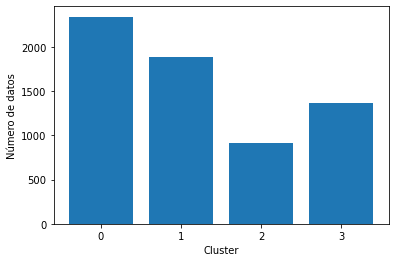

In [20]:
rects = plt.bar(indexes, values)
plt.xlabel('Cluster')
plt.ylabel('Número de datos')
plt.xticks(indexes)

### Análisis de datos por cluster

Recuerda que realizamos la agrupación con los datos estandarizados, lo que nos ayuda con el desempeño de los algoritmos pero no hace que sean fácilmente interpretables por una persona. Para esto, utilizaremos el objeto `standard_scaler` que definimos inicialmente. Este objeto nos permite realizar una transformación inversa mediante el método `inverse_transform()`, lo que retornará el conjunto de datos en su escala original:

In [21]:
# inverse_transform(data) retorna un arreglo de Numpy
data_original = standard_scaler.inverse_transform(data)
# Utilizaremos las columnas de la variable data para construir un DataFrame
data_original = pd.DataFrame(data_original, columns=data.columns)
# Si añadimos una columna con el resultado de la agrupación, 
# podremos interpretar el resultado fácilmente
data_original['Cluster'] = mejor_modelo.labels_
data_original

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,Cluster
0,11.091418,0.678736,1.166757,51.224667,0.196503,95.102349,81.153415,0.998144,3.642585,0.425207,12.273098,0
1,11.368098,0.714899,1.076856,51.757659,0.150704,94.925272,80.229619,0.995853,3.766852,0.629721,12.237926,0
2,10.681273,0.854871,1.432067,55.325475,0.097510,117.321509,327.596772,1.034387,2.966008,0.846459,12.954406,3
3,14.136565,0.940244,0.263259,28.526766,0.428167,243.641087,331.235036,1.004244,3.076522,1.638521,12.459896,1
4,11.286462,0.622551,1.167118,56.337446,0.141715,85.887796,78.834860,0.998896,3.864429,0.474253,12.290298,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,9.812656,0.519421,1.459374,56.361282,0.102864,78.675282,353.406283,1.031746,3.142622,0.829744,13.233414,3
6493,13.290458,0.792301,0.220811,24.958493,0.371316,254.372135,364.995441,1.004352,2.970350,1.710251,12.567409,1
6494,14.844921,0.865045,0.300987,24.598068,0.418014,215.547898,369.972034,0.999167,2.910071,1.849681,13.845125,1
6495,11.230268,0.639650,1.078172,54.398855,0.176503,113.334984,83.883090,0.998868,3.741809,0.418961,12.154768,0


Con los datos escalados, realizaremos un diagrama de cajas por cada variable, para así describir los clusters resultantes:

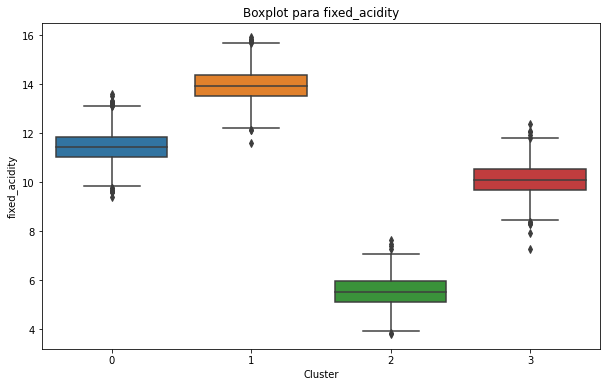

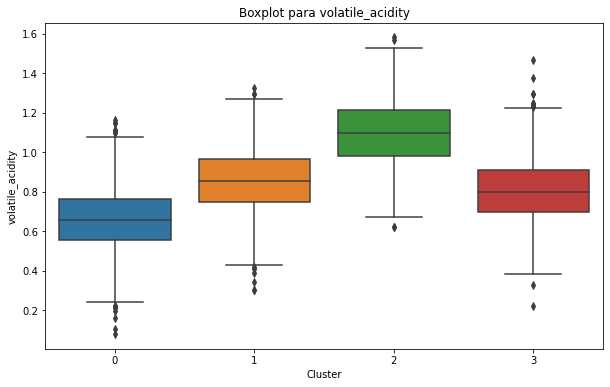

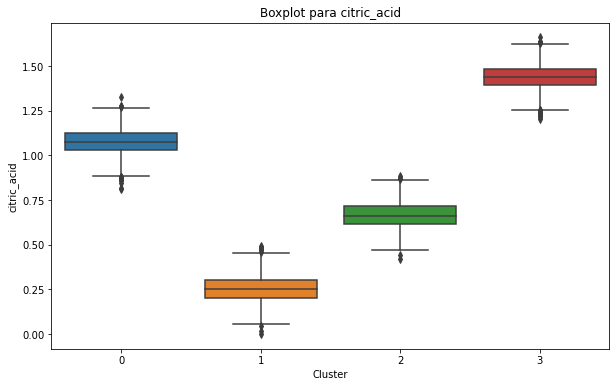

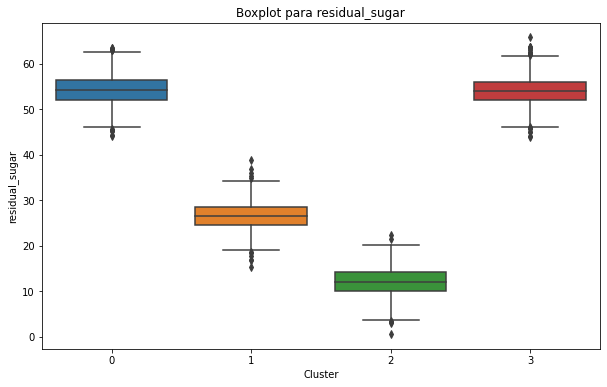

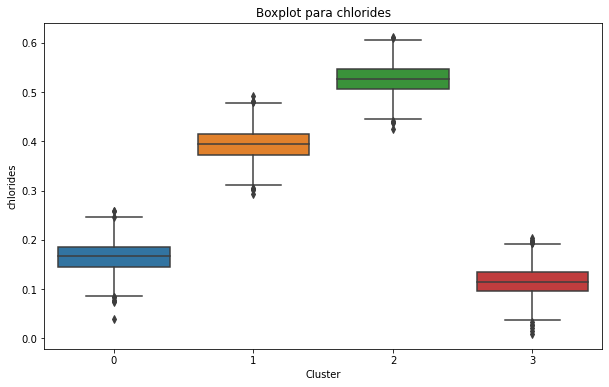

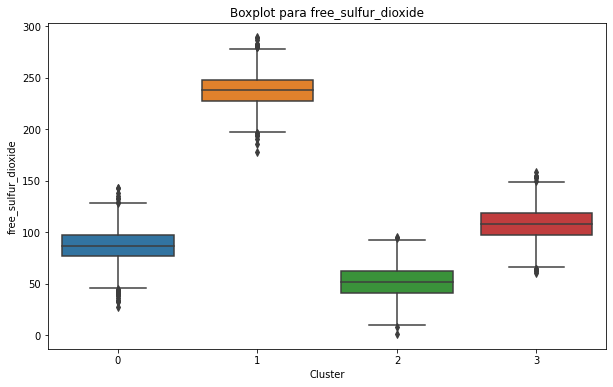

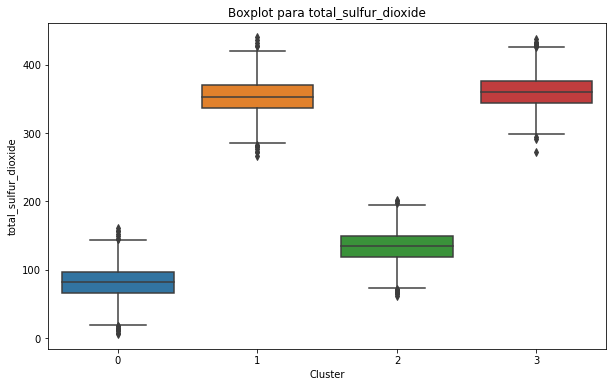

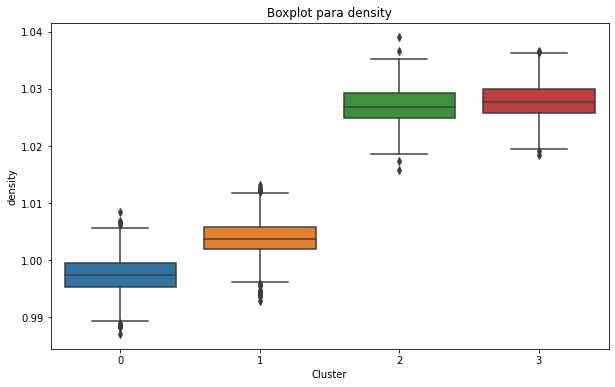

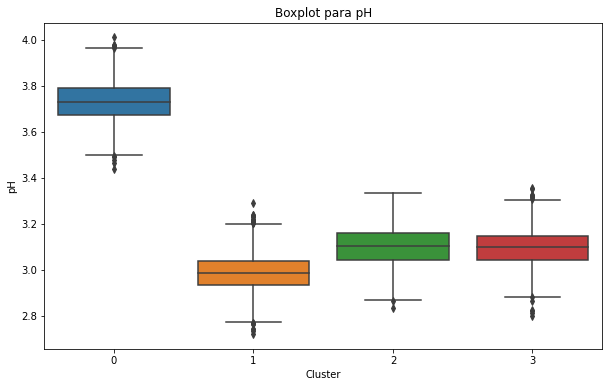

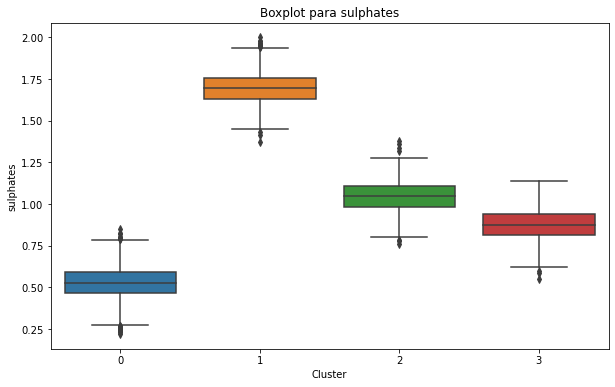

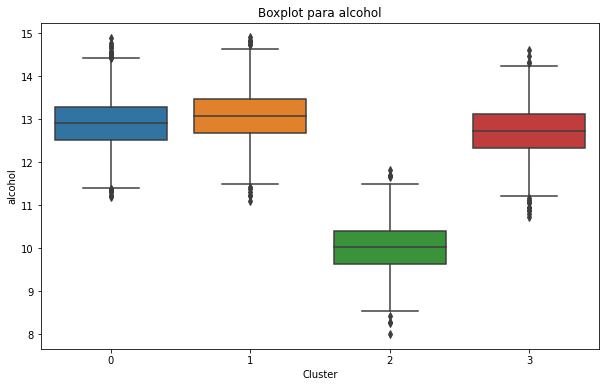

In [22]:
# Obtenemos las variables, ignorando la columna Cluster
columns = data_original.columns.drop(['Cluster'])
# Creamos un diagrama por cada variable
for column in columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=column, data=data_original)
    plt.title(f'Boxplot para {column}')
    plt.show()

Otra forma de interpretar el resultado de la agrupación es utilizando los centroides resultantes. A continuación, obtendremos los centroides de cada grupo con el atributo `cluster_centers_` del objeto `mejor_modelo`. Aplicaremos el mismo método `inverse_transform()` para obtener centroides más interpretables:

In [23]:
centroids_array = mejor_modelo.cluster_centers_
centroids_original = standard_scaler.inverse_transform(centroids_array)
centroids_original

array([[1.14300035e+01, 6.59252938e-01, 1.07556041e+00, 5.42845596e+01,
        1.65566369e-01, 8.66475679e+01, 8.14735419e+01, 9.97454756e-01,
        3.73060943e+00, 5.27554670e-01, 1.29129380e+01],
       [1.39404622e+01, 8.53963658e-01, 2.51677871e-01, 2.65932470e+01,
        3.94240634e-01, 2.37999876e+02, 3.53467788e+02, 1.00385450e+00,
        2.98640082e+00, 1.69310150e+00, 1.30710760e+01],
       [5.53353619e+00, 1.09631760e+00, 6.63686329e-01, 1.20839938e+01,
        5.26646629e-01, 5.14508010e+01, 1.33576291e+02, 1.02703370e+00,
        3.09955418e+00, 1.04611496e+00, 1.00180880e+01],
       [1.00943315e+01, 8.01699474e-01, 1.43872080e+00, 5.40186923e+01,
        1.14802195e-01, 1.07791008e+02, 3.60621267e+02, 1.02777249e+00,
        3.09446129e+00, 8.75710246e-01, 1.27179110e+01]])

Ahora transformaremos el arreglo resultante en un DataFrame con las columnas de la variable `data`:

In [24]:
centroids = pd.DataFrame(centroids_original, columns=data.columns)
centroids

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,11.430003,0.659253,1.075560,54.284560,0.165566,86.647568,81.473542,0.997455,3.730609,0.527555,12.912938
1,13.940462,0.853964,0.251678,26.593247,0.394241,237.999876,353.467788,1.003855,2.986401,1.693102,13.071076
2,5.533536,1.096318,0.663686,12.083994,0.526647,51.450801,133.576291,1.027034,3.099554,1.046115,10.018088
3,10.094331,0.801699,1.438721,54.018692,0.114802,107.791008,360.621267,1.027772,3.094461,0.875710,12.717911


La caracterización la podemos hacer a partir de estos valores promedios, por ejemplo:
- **Clúster 0 (2339 muestras):** se caracteriza por tener valores altos de `residual_sugar`y los valores más bajos de `total_sulfur_dioxide`y `sulphates`.

- **Clúster 1 (1884 muestras):** en promedio, presenta valores muy altos de `free_sulfur_dioxide`, `total_sulfur_dioxide` y `fixed_acidity`, así como los valores más bajos de `citric_acid` y `chlorides`.  

- **Clúster 2 (910 muestras):** se caracteriza por valores muy bajos de `fixed_acidity`, `residual_sugar` y `free_sulfur_dioxide`, así como valores medios de `total_sulfur_dioxide`.

- **Clúster 3 (1364 muestras):** presenta valores altos `residual_sugar` y `total_sulfur_dioxide`, pero los mas bajos de `chlorides`.

Esta información puede entonces ser validada por los expertos, los cuales pueden ayudar entonces a asignar etiquetas de calidad a los diferentes grupos.

## Cierre

En este tutorial hemos utilizado las clases `KMeans` y `KMedoids` para entrenar y evaluar modelos de agrupación. Específicamente, realizamos una selección del hiperparámetro _k_ mediante el método del codo y el método de la silueta, interpretando los _k_ grupos resultantes mediante la identificación de sus centroides y la generación de diagramas de caja con `seaborn`.

<font size="3">**Hands-on**  

* La clase `KMeans` permite establecer el parámetro `n_init` para ejecutar el algoritmo con diferentes inicializaciones de los centroides, seleccionando el que retorna la menor inercia. ¿Qué pasaría si aumentas el número de ejecuciones?

* Ejecutamos el algoritmo KMedoides utilizando la distancia euclidiana. La clase `KMedoids` permite cambiar la métrica de distancia con el parámetro `metric`. Intenta utilizar otras distancias, como la distancia Manhattan. 

---
*Creado por: Nicolás Díaz*  
*Revisado por: Haydemar Nuñez*  
*Versión de: Diciembre 8, 2023*  
*Universidad de los Andes*   